## Multirate Signal Processing - Seminar 2

Improved filterbank using filter design techiques. 

Import the necessary libraries first.

In [53]:
import numpy as np
import sound
import scipy.signal as sig
import scipy.io.wavfile as wav
import pyaudio
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8,6]

Load audio file from folder data.

In [54]:
pathToAudio = "data/Track48.wav"
fs, data = wav.read(pathToAudio)
duration = 5 # seconds
audio = np.array(data[:fs*duration,0]) # use only one channel
print('Sampling rate: {}'.format(fs))
print('Data Type: ', audio.dtype)
print('Shape of one channel: {}'.format(audio.shape))

Sampling rate: 44100
('Data Type: ', dtype('int16'))
Shape of one channel: (220500,)


### From HW 1

Create filterbank using remez function.

In [55]:
filterTabs = 32
filterbank = []
#lowpass
filterbank.append(sig.remez(filterTabs,[0, 0.125, 0.15, 0.5],[1 , 0],[1, 1000]))
# bandpass low
filterbank.append(sig.remez(filterTabs,[0, 0.1, 0.125, 0.25, 0.275, 0.5],[0, 1 , 0],[1000, 1, 1000]))
# bandpass high
filterbank.append(sig.remez(filterTabs,[0, 0.225, 0.25, 0.375, 0.4, 0.5],[0, 1 , 0],[1000, 1, 1000]))
#highpass
filterbank.append(sig.remez(filterTabs,[0, 0.35, 0.375, 0.5],[0, 1],[1000, 1]))

Plot filter impulse responses in one window

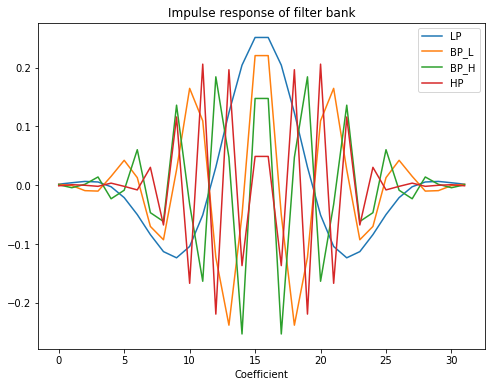

In [56]:
f1 = plt.figure()
for h in filterbank:
    plt.plot(h)
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Impulse response of filter bank')
plt.xlabel('Coefficient')
plt.show()

Plot filter frequency responses:

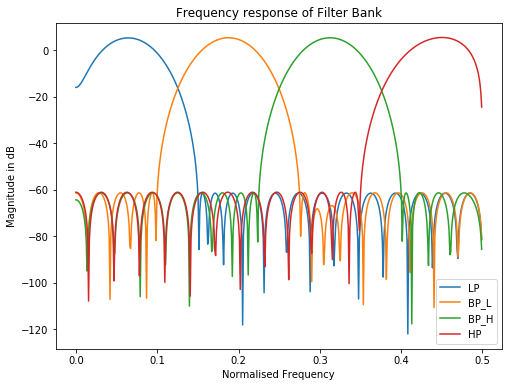

In [57]:
for h in filterbank:
    w,H = sig.freqz(h)
    # plot magnitude
    plt.plot(w/(np.pi*2),20*np.log10(np.abs(H)))
plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Frequency response of Filter Bank')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.show()

### Design filters using windowing

Definition of helper functions:
* sinc
* impulse response of ideal lowpass (sincInpulse)
* Cosine modulator 

In [58]:
def sinc(x):
    return (np.sin(x)/x)

def sincImpulse(N,wc):
    n = np.arange(0,N)
    delay = (N-1)/2.0
    # h = (wc/np.pi) * (np.sin(wc *(n-delay))/(np.pi*(n-delay)))
    h = (wc/np.pi)*sinc((n-delay)*wc)
    return h

def cosModulator(N,w0):
    n = np.arange(0,N)
    # delay = (N-1)/2.0
    # m = (1/np.pi)*np.cos(w0*np.pi*(n-delay))
    m = np.cos(w0*n)
    return m

Definitions of window functions:
* raised cosine window
* sin window

In [59]:
def raisedCosWinow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        c = 0.5-0.5*np.cos(2*np.pi/N*(n+0.5))
    else: # odd
        c = 0.5-0.5*np.cos(2*np.pi/(N+1)*(n+1))    
    return c

def sinWindow(N):
    n = np.arange(0,N)
    if (N%2 == 0): # even
        s = np.sin(np.pi/N*(n+0.5))
    else:
        s = np.sin(np.pi/(N+1)*(n+1))
    return s

Filterbank implementation:

In [60]:
def createFilterbank(nBands,nTabs):
    """Function to create a cosine modulated filterbank with nBands subbands and nTabs coefficients.
    It uses a raised cosine window function."""
    wLp = np.pi/(2*nBands)
    prototype = sincImpulse(nTabs, wLp) * raisedCosWinow(nTabs)
    fb = []
    for i in range(0,nBands):
        mod = cosModulator(nTabs, (2*i+1) * np.pi/(2*nBands))
        fb.append(2 * prototype * mod)
        
    return fb


In [61]:
nSubbands = 4
nTabs = 4
FB = createFilterbank(nSubbands,nTabs)

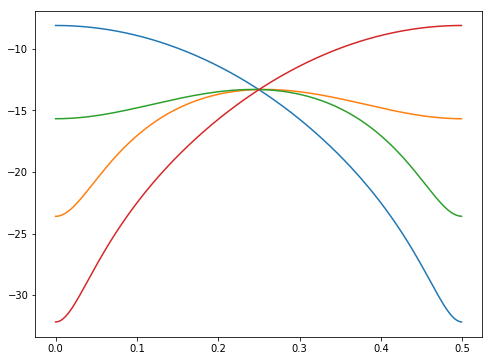

In [63]:
for h in FB:
    W,H = sig.freqz(h)
    plt.plot(w/(2*np.pi),20*np.log10(np.abs(H)))
plt.show()

Use filterbank on audio signal and downsample

In [64]:
decomposed = [np.convolve(h,audio,mode='full') for h in FB]
downsampledBands = [s[::nSubbands] for s in decomposed]

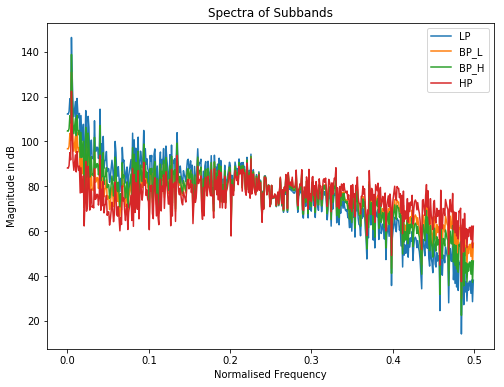

In [65]:
for s in decomposed:
    w,H = sig.freqz(s)
    # plot magnitude
    plt.plot(w/(np.pi*2),20*np.log10(np.abs(H)))

plt.legend(['LP','BP_L','BP_H','HP'])
plt.title('Spectra of Subbands')
plt.xlabel('Normalised Frequency')
plt.ylabel('Magnitude in dB')
plt.show()

In [29]:
i = 1
fs_ds = int(fs/nSubbands)
for band in downsampledBands:
    print("Playing {}th subband.".format(i))
    sound.sound(band,fs_ds)
    i += 1

Playing 1th subband.
* done
Playing 2th subband.
* done
Playing 3th subband.
* done
Playing 4th subband.
* done
Playing 5th subband.
* done
Playing 6th subband.
* done
Playing 7th subband.
* done
Playing 8th subband.
* done


Plot excert of signal and subband k=0

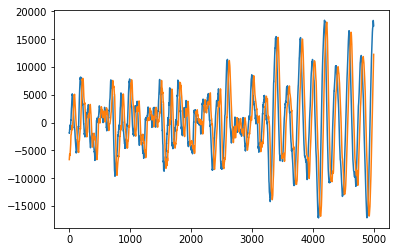

In [39]:
plt.plot(audio[55000:60000])
plt.plot(decomposed[0][55000:60000])
plt.show()

Reconstruction:
* upsampling and filtering
* add subbands together

In [40]:
zeroBands = [np.zeros_like(band) for band in decomposed]
usBands = []
for zBand, dsBand in zip(zeroBands, downsampledBands):
    zBand[::4] = dsBand
    usBands.append(zBand)

filterdUs = [np.convolve(h,band,mode='full') for h,band in zip(FB, usBands)]

In [41]:
recon = np.zeros_like(filterdUs[0])
for band in filterdUs:
    recon += band
sound.sound(recon,fs)

* done


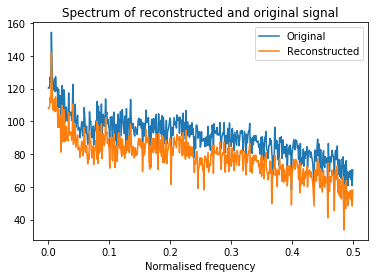

In [45]:
wOriginal, hOriginal = sig.freqz(audio)
plt.plot(wOriginal/(np.pi*2),20*np.log10(np.abs(hOriginal)))

w,H = sig.freqz(recon)
plt.plot(w/(np.pi*2),20*np.log10(np.abs(H)))

plt.title('Spectrum of reconstructed and original signal')
plt.xlabel('Normalised frequency')
plt.legend(['Original', 'Reconstructed'])
plt.show()

In [66]:
print(FB[0].shape)

(4,)


In [67]:
signal = np.array([[1.0, 3.0, 3.0, 2.0, 5.0]]).T

In [68]:
print(signal)

[[1.]
 [3.]
 [3.]
 [2.]
 [5.]]


In [69]:
print(signal.shape)

(5, 1)


In [70]:
def convMatrix(h,N):
    hLen = h.shape[0]
    Mat = np.zeros((hLen+N-1,N))
    for shift in range(0,N):
        Mat[shift:shift+hLen,shift] = h
    return Mat

In [71]:
cMat = convMatrix(FB[0],5)
print(cMat)

[[0.03453084 0.         0.         0.         0.        ]
 [0.19588081 0.03453084 0.         0.         0.        ]
 [0.14992068 0.19588081 0.03453084 0.         0.        ]
 [0.01321438 0.14992068 0.19588081 0.03453084 0.        ]
 [0.         0.01321438 0.14992068 0.19588081 0.03453084]
 [0.         0.         0.01321438 0.14992068 0.19588081]
 [0.         0.         0.         0.01321438 0.14992068]
 [0.         0.         0.         0.         0.01321438]]


In [72]:
out = np.dot(cMat,signal)

In [73]:
print(out)

[[0.03453084]
 [0.29947333]
 [0.84115562]
 [1.11968051]
 [1.05382099]
 [1.31888853]
 [0.77603215]
 [0.0660719 ]]
